In [1]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
import bokeh
from bokeh.plotting import figure
from bokeh.models import WMTSTileSource
from bokeh.io import output_notebook, show
from bokeh.palettes import Viridis6 as palette
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper,
    LinearColorMapper
)
output_notebook()

Loading BokehJS ...

Read in the data below.

We omit **date** and **zipcode** features from the dataset as we will not use these in our analysis.

In [2]:
# Read in the dataset into pandas for easy manipulation and plotting
df = pd.read_csv('kc_house_data.csv')
# We wont use the features below in our analysis, so we drop them
df.drop(labels=['date','zipcode'], inplace=True, axis=1)
# Drop empties and nan rows
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(subset=['id'], inplace=True, keep='last')
# shuffle data
df = df.sample(frac=1.)
df.reset_index(drop=True,inplace=True)
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,7291700065,455000.0,4,1.50,1880,11400,1.0,0,0,3,7,1280,600,1955,0,47.7718,-122.381,1880,11400
1,6140100875,420000.0,3,1.00,1060,8097,1.0,0,0,4,7,940,120,1923,0,47.7144,-122.351,1560,7940
2,3905040070,540000.0,3,2.50,1670,5146,2.0,0,0,3,8,1670,0,1991,0,47.5707,-121.999,1940,5146
3,5592900205,380000.0,2,1.75,1800,7191,1.0,0,3,4,7,990,810,1952,0,47.4828,-122.191,1940,7400
4,6817801020,475000.0,3,1.50,1930,11092,1.0,0,0,3,7,1500,430,1983,0,47.6340,-122.033,1230,10964


# Average price per bedroom and bathroom

First, lets plot the average price bedroom / bathroom relationship so we can get a visual understanding of the data.

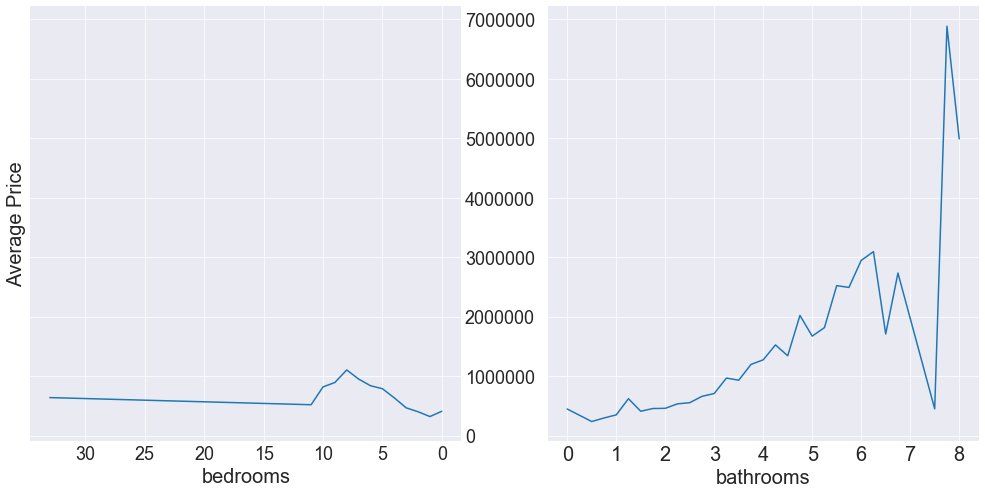

In [3]:
fig, (ax, ax2) = plt.subplots(figsize=(17,8), ncols=2, sharey=True)
ax.invert_xaxis()
ax.yaxis.tick_right()
ax.set_ylabel("Average Price", fontsize = 20)
ax.set_xlabel("Bedrooms", fontsize=20)
ax2.set_xlabel("Bathrooms", fontsize=20)
df.groupby(['bedrooms'])['price'].mean().plot(kind='line', legend=False, ax=ax, fontsize=18)
df.groupby(['bathrooms'])['price'].mean().plot(kind='line', ax=ax2, fontsize=20)
plt.show()

In [4]:
# explicit list of average price per bedroom / bathroom
print(df.groupby(['bedrooms'])['price'].mean())
print(df.groupby(['bathrooms'])['price'].mean())

bedrooms
0     4.095038e+05
1     3.211801e+05
2     4.022304e+05
3     4.677508e+05
4     6.361711e+05
5     7.893550e+05
6     8.394136e+05
7     9.511847e+05
8     1.105077e+06
9     8.939998e+05
10    8.193333e+05
11    5.200000e+05
33    6.400000e+05
Name: price, dtype: float64
bathrooms
0.00    4.481600e+05
0.50    2.373750e+05
0.75    2.969226e+05
1.00    3.489879e+05
1.25    6.212167e+05
1.50    4.104777e+05
1.75    4.563012e+05
2.00    4.593070e+05
2.25    5.346389e+05
2.50    5.540258e+05
2.75    6.607885e+05
3.00    7.085801e+05
3.25    9.687698e+05
3.50    9.319899e+05
3.75    1.197217e+06
4.00    1.275007e+06
4.25    1.525774e+06
4.50    1.343556e+06
4.75    2.021304e+06
5.00    1.673492e+06
5.25    1.817177e+06
5.50    2.522300e+06
5.75    2.492500e+06
6.00    2.946833e+06
6.25    3.094000e+06
6.50    1.709445e+06
6.75    2.734000e+06
7.50    4.500000e+05
7.75    6.885000e+06
8.00    4.990000e+06
Name: price, dtype: float64


### Average price per bedroom / bathroom doesn't make sense

We would expect that the average price would monotonically increase with #bedrooms /  # bathrooms, but that is not what is graphed above. This would indicate that there are some price outliers.

The average price per bedroom peaks at around 7 bedrooms, and then falls off as the number of bedrooms increases. This seems strange as usually the more bedrooms in a house, the bigger the house and therefore the more expensive a house.

As for the average price per #bathrooms, this increases steadily as expected until 6 bathrooms, then fluctuates wildly between 6 and 8 bathrooms. Above 6 bathrooms the average price does not behave as expected (monotonic increase).

Also, we see that the average price per #bedrooms and average price per #bathrooms differ by a factor of 7 as the number when bedrooms > 10 and bathrooms > 7. This is definitely an indicator of some outliers / incorrect data.

#### Segmenting price by Area

Let us bin houses into 5 different sqft area ranges, and segment house price by those categories. House area is usually a good indicator of price, so we expect the average price to be monotonically increasing.

We use sqft_living15 as this is a more recent indiocator of house size when they were sold.

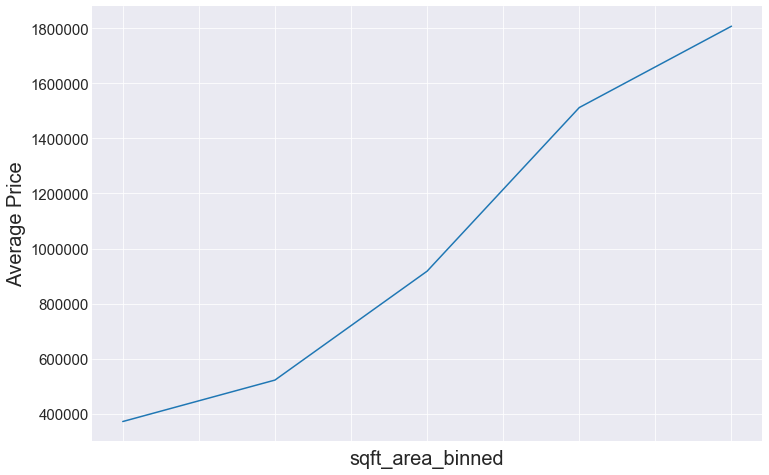

In [5]:
# Segment by sqft_area and bin prices into 5 bins
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel("Average Price", fontsize=20)
ax.set_xlabel("", fontsize=20)
df['sqft_area_binned']=pd.cut(x=df['sqft_living15'], bins=5)
df.groupby(['sqft_area_binned'])['price'].mean().plot(kind='line', fontsize=15)
plt.show()

Indeed, as the binned area of the house increases, so do this average price, almost linearly.


# Price Outliers - Interquartiles

Let's define a price outlier, using a simple inqterquaretile range, as any price that lies either 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.

In a box and whisker plot (shown below), this would be any data point above or below (to the right or left as it is oriented horizontally) the right or left "whiskers" respectively.

We use the same 5 bins as above.

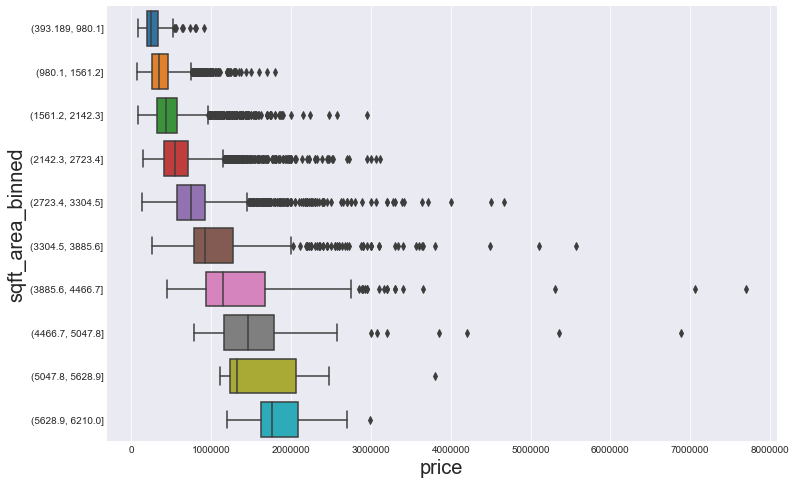

In [6]:
df['sqft_area_binned']=pd.cut(x=df['sqft_living15'], bins=10)
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('', fontsize=20)
ax.set_ylabel('', fontsize=20)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('xtick', labelsize=15)
sns.boxplot(x=df['price'], y=df['sqft_area_binned'], orient='h', ax=ax)
plt.show()

We can see that there are several price outliers for each of the 5 binned sqft house areas. Particularly in the 1561-3885 sqft_living15 range, as many of the house prices lie above 1-1.5 million in price.

Let's get a list of these house id's using interquartile ranges.

In [7]:
class Outliers:
    """
    Identifies outliers
    """
    
    def __init__(self, id_col='id', binned_col='sqft_area_binned', target_col='price'):
        self.id_col       =  id_col
        self.binned_col   =  binned_col
        self.target_col   =  target_col
        
    def find_furthest_outlier(self, data, lower, upper):
        """
        Get the maximum outliers for each bin, return a list of outlier ids
        INPUT: data (pandas df), lower (pandas series lower quartile), upper (pandas series upper quartile)
        OUTPUT: ids (list of unique ids)
        """
        ids = []
        # Loop over each bin
        for i in range(len(upper)):

            tmp_lower_df = data[(data[self.binned_col] == lower.index[i]) & (data[self.target_col] < lower[i])]
            # if there are any prices below lower IQR...
            if tmp_lower_df.shape[0] > 0:
                tmp_lower_id = tmp_lower_df.loc[tmp_lower_df[self.target_col].idxmin()][self.id_col]
                if 'tmp_lower_id' in locals():
                    # get distance between lower bound and lowest price
                    lower_dist = abs(tmp_lower_df[tmp_lower_df[self.id_col] == tmp_lower_id][self.target_col].values[0] - lower[i])

            tmp_upper_df = data[(data[self.binned_col] == upper.index[i]) & (data[self.target_col] > upper[i])]
            # if there are any prices above upper IQR...
            if tmp_upper_df.shape[0] > 0:    
                tmp_upper_id = tmp_upper_df.loc[tmp_upper_df[self.target_col].idxmax()][self.id_col]
                if 'tmp_upper_id' in locals():
                    # get distance between upper bound and highest price
                    upper_dist = abs(tmp_upper_df[tmp_upper_df[self.id_col] == tmp_upper_id][self.target_col].values[0] - upper[i])

            if 'upper_dist' in locals() and 'lower_dist' in locals():
                if upper_dist > lower_dist:
                    ids.append(tmp_upper_id)
                else:
                    ids.append(tmp_lower_id)
            elif 'upper_dist' in locals() and 'lower_dist' not in locals():
                ids.append(tmp_upper_id)
            elif 'upper_dist' not in locals() and 'lower_dist' in locals():
                ids.append(tmp_lower_id)
        # return a set as some tmp variables will not be overwritten with every bucket and so will
        # append to the list more than once
        return set(ids)
    
    def remove_outliers(self, data):
        """
        Keep re-calculating outliers with each set of min / max outliers removed at each iteration until there are no more
        INPUT: data (pandas dataframe)
        OUTPUT: outlier_ids (a list of outlier ids)
        """
        outlier_ids = []
        while 1:
            # First quartile
            q1 = data.groupby([self.binned_col])[self.target_col].quantile(0.25)
            # Third quartile
            q3 = data.groupby([self.binned_col])[self.target_col].quantile(0.75)
            # IQR
            iqr = q3 - q1
            # Upper and lower bounds
            upper = q3 + 1.5*iqr
            lower = q1 - 1.5*iqr

            ids = self.find_furthest_outlier(data, lower, upper)

            if ids:
                # Remove the outlier rows from the data each iteration
                data = data[~data[self.id_col].isin(ids)]
                data.reset_index(inplace=True, drop=True)
                outlier_ids += list(ids)
            else:
                break
        return outlier_ids

In [8]:
get_out = Outliers()
outlier_ids = get_out.remove_outliers(df)

### Outlier ID's

In [9]:
print("There are", len(outlier_ids), "outliers. The first 10 price outlier id's are:\n",outlier_ids[:10])

There are 1225 outliers. The first 10 price outlier id's are:
 [9208900037, 333100295, 853200010, 1250202285, 2470100110, 6762700020, 1924059029, 3303850390, 323079101, 1176001310]


This seems like a lot of outliers; probably too much for this dataset. The issue here is that there are probably small house in very expensive areas which is why our logic detects so many outliers - if we segmented by location and sqft_area, we may get a better idea of the outliers.

# Visualization

We will not use the latitude and longitude features in fitting our linear regression model for part 4 of this question, as there is not a linear relation between location and price (this would be better suited for a **clustering** model).

So, let's visualize house price by location using an interactive Bokeh visualization.

In [10]:
def wgs84_to_web_mercator(df, lon="lon", lat="lat"):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

In [11]:
df = wgs84_to_web_mercator(df, lon='long', lat='lat')
xs = df["x"]
ys = df["y"]
house_ids = df["id"]
prices = df["price"]

source = ColumnDataSource(data=dict(
    x=xs,
    y=ys,
    name=house_ids,
    rate=prices,
))

In [12]:
# Color scale for plotting
color_mapper = LogColorMapper(palette=palette)
# Tool to interact with map
TOOLS = "pan,wheel_zoom,reset,hover,save"
USA = x_range,y_range = ((df['x'].min(),df['x'].max()), (df['y'].min(),df['y'].max()))
# Define figure
p = figure(title="King County House Sales - 2015", tools=TOOLS, x_range=x_range, y_range=y_range,
          plot_width=800, plot_height=600)
p.axis.visible = False
# Get info on world map
url = 'http://a.basemaps.cartocdn.com/dark_all/{Z}/{X}/{Y}.png'
attribution = "Tiles by Carto, under CC BY 3.0. Data by OSM, under ODbL"
p.add_tile(WMTSTileSource(url=url, attribution=attribution))
p.grid.grid_line_color = None
# Define circle points
p.circle('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

# Define mouse movement and display data
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("id", "@name"),
    ("House Price", "$@rate"),
    ("(X, Y)", "($x, $y)"),
]
show(p)

Why is it cool? Because we can see some clear patterns:

1. Cheaper houses are mostly to the south, far from the city of Seattle
2. More expensive houses are to the north, with most expensive areas being around Clyde Hill, on the waterfront in downtown Seattle and along the waterline in the bay
3. Least expensive houses are down south in Des Moines and kens - perhaps due to the longer distance from the city of Seattle

With this information, we now have a good understanding of where the expensive houses are and why - northern areas of King County, and coastlines with a waterview. From a business perspective we can use this information in the following way:

1. We now know where the wealthiest people reside (down to a very fine degree of accuracy), so could, say, market to them appropriately; we see a lot of expensive houses right by the waterfront - maybe they like boats, or water activities.
2. We can use this map to complement our regression model in predicting house price - say we are making predictions in house price using our model later on, we can use the location of the house and this map to make a more accurate prediction of the house price and letting us, say, make a better investment decision.



# Feature Covariances

Before we build a model, let's visualize the feature covariances to see if there are any features that may be related.

In [13]:
# We no longer need these columns
df.drop(labels=['x','y','sqft_area_binned'], inplace=True, axis=1)

In [14]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [15]:
def scale_features(x, test_flag=False, x_test=None):
    """
    Scale features (column-wise) of input data
    INPUT: x (training data numpy array), x_test (test data numpy array)
    """
    # Scale all features - train scaler on train data only
    scaler = StandardScaler().fit(x)
    # apply learned sclaer to train and test data
    x_scaled = scaler.fit_transform(x)
    if test_flag == True:
        x_test_scaled = scaler.fit_transform(x_test)
        return x_scaled, x_test_scaled
    else:
        return x_scaled

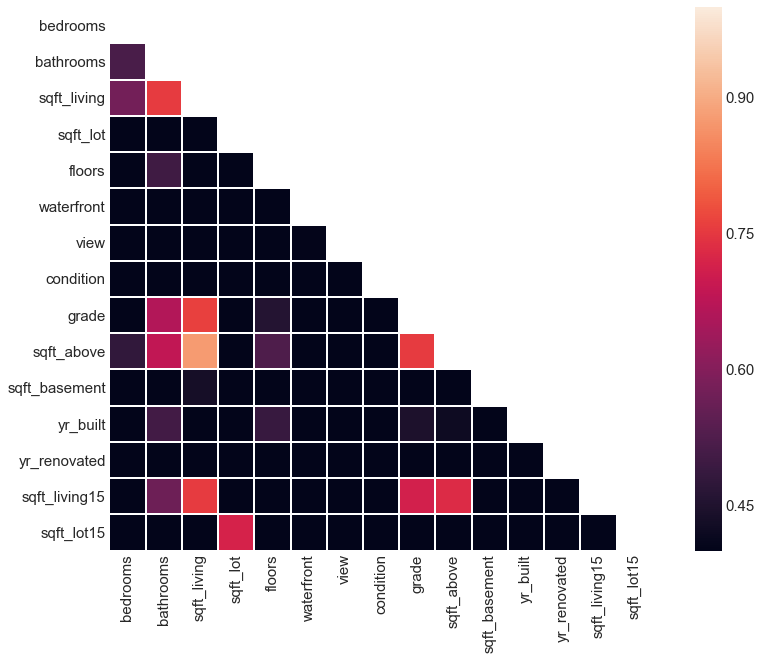

In [16]:
# Scale features
cols = [i for i in df.columns if i not in ['price','id','lat','long']]
warnings.filterwarnings("ignore")
x = df.as_matrix(columns=cols)
x = scale_features(x=x)
# calculate covariance matrix
Sigma = (1/x.shape[0])*np.dot(x.T,x)
Sigma = abs(Sigma)

mask = np.zeros_like(Sigma)
mask[np.triu_indices_from(Sigma)] = True
with sns.axes_style("white"):
    matplotlib.rc('ytick', labelsize=15)
    matplotlib.rc('xtick', labelsize=15)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(Sigma, mask=mask, square=True, vmin=0.4, ax=ax, linewidths=1, xticklabels=cols, yticklabels=cols)
    plt.show()

Indeed we see, that after scaling, some features such as sqft_above and sqft_living do have some non-negligible relationship. sqft_living15 and sqft_living also have some relationship, so perhaps not many houses were extended / renovated between being first built and 2015, so their area would stay the same. This could indicate that sqft_living is a redundant feaure.

This may have colinearity and significance test issues once we train the model. It is good to note this and keep it in mind.


# Build Model

Fit simple Ordinary Least Squares (OLS) linear model - assume linear relationship between features and price.


## Background on OLS

OLS is a linear model given by

$$y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + ... + \beta_p x_{ip}$$

for the $i$'th observation, y is the price, $\beta_k$ is the coefficient (slope) of the $k$'th feature and $p$ is the number of features (sqft_living, bedrooms etc.).

OLS will minimize the cost function $J$, through gradient descent

$$J = \frac{1}{2m}\sum_i^m (XW - y)^2$$

where $X$ is the design (data) matrix, $W$ is a vector of weights (coefficients) and $y$'s are the prices. The algorithm minimizes the cost $J$ by moving in the direction of the negative gradient given below (i.e. updating weights $W$ so that the cost decreases)

$$\frac{\partial J}{\partial w_j} = -\sum_i(y_i - w_j)x_i$$

In any optimization implementation, it is important to scale our features so that gradient descent doesn't oscillate too much and find's a minimum faster (or finds a minimum at all!). Scaling subtracts the mean and divides by the standard deviation of each feature (column).

In [17]:
df['sqft_area_binned']=pd.cut(x=df['sqft_living15'], bins=10)
df.drop(labels=['sqft_area_binned'], inplace=True, axis=1)
# Split data into training and testing sets to measure error / accuracy later
df, df_test = train_test_split(df, test_size=0.15)
df.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [18]:
def get_matrices(data, data_test, use_cols, target_col):
    """
    Convert columns of pandas dataframe to matrix
    INPUT: data (pandas dataframe), use_cols (columns to convert to matrix), target_col (string)
    OUTPUT: x (train data numpy array), y (train target numpy array), x_test (test data numpy array),
    y_test (train target numpy array)
    """
    warnings.filterwarnings("ignore")
    x = data.as_matrix(columns=use_cols)
    y = data.as_matrix(columns=[target_col])
    x_test = data_test.as_matrix(columns=use_cols)
    y_test = data_test.as_matrix(columns=[target_col])
    return x,y,x_test,y_test

In [19]:
cols_model1 = [i for i in df.columns if i not in ['price','id','lat','long']]
x,y,_,_ = get_matrices(data=df, data_test=df_test, use_cols=cols_model1, target_col='price')
# Scale x
x = scale_features(x=x)

In [20]:
print("Model 1 will be trained using features:\n",cols_model1)

Model 1 will be trained using features:
 ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']


### Model 1

In [21]:
# Add vector of 1's to first column of x for the constant (bias) term
X2 = sm.add_constant(x)
# Fit OLS model
est_model1 = sm.OLS(y, X2)
est2_model1 = est_model1.fit()
print(est2_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2474.
Date:                Thu, 14 Jun 2018   Prob (F-statistic):               0.00
Time:                        20:18:45   Log-Likelihood:            -2.4961e+05
No. Observations:               18220   AIC:                         4.993e+05
Df Residuals:                   18205   BIC:                         4.994e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.424e+05   1597.603    339.539      0.0

In [22]:
# Remind ourselves what is the mapping between xi and feature
for k in zip(["x"+str(i) for i in range(1,16)], cols_model1):
    print(k)

('x1', 'bedrooms')
('x2', 'bathrooms')
('x3', 'sqft_living')
('x4', 'sqft_lot')
('x5', 'floors')
('x6', 'waterfront')
('x7', 'view')
('x8', 'condition')
('x9', 'grade')
('x10', 'sqft_above')
('x11', 'sqft_basement')
('x12', 'yr_built')
('x13', 'yr_renovated')
('x14', 'sqft_living15')
('x15', 'sqft_lot15')


### Model 1 statistics

We see that some features have a p-value greater than $\alpha=0.05$. Therfore changes in this feature will not affect the price of the house, so we can omit these features from our model (either set the coefficient to 0 or retrain a model without using that feature).

The $R^2$ value is 0.65, meaning that 65% of the varience in price can be explained by the features, the remaining 35% is attributed to uknown variables or inherent variability.

Finally we see that the statistics suggest there could be multicolinearity issues in the data. Multicolinearity arises when one feature $X_1$ can be explained, to some high degree of accuracy, by a linear combination of another feature $X_2$

$$X_1 = \lambda_0 + \lambda_1 X_2$$

for some constants $\lambda_0, \lambda_1$

This is a problem, as we do not want any features to be linear combinations of any other features. Multicolinearity does not always affect the predictive power of a model, but can impede our ability to make judgements on the importance of individual features of the data.

In some sense, it makes sense that multicolinearity should arise with this dataset as multiple features are related to **area** in the house. Let us **remove some features from the training set and retrain the model.** Let's remove some features from the model.

Hopefully retraining a new model with these new features will not only resolve the colinearity issues, but also yield a more powerful and predictive model.

### Model 2

In [23]:
exclude_cols = ['price','id','lat','long','sqft_living','sqft_lot','sqft_above','sqft_basement','yr_renovated']
cols_model2 = [col for col in df.columns if col not in exclude_cols]
x,y,_,_ = get_matrices(data=df, data_test=df_test, use_cols=cols_model2, target_col='price')
# Scale x
x = scale_features(x=x)

In [24]:
print("Model 2 will be trained using features:\n",cols_model2)

Model 2 will be trained using features:
 ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'sqft_living15', 'sqft_lot15']


In [25]:
X2 = sm.add_constant(x)
est_model2 = sm.OLS(y, X2)
est2_model2 = est_model2.fit()
print(est2_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     3001.
Date:                Thu, 14 Jun 2018   Prob (F-statistic):               0.00
Time:                        20:19:17   Log-Likelihood:            -2.5045e+05
No. Observations:               18220   AIC:                         5.009e+05
Df Residuals:                   18209   BIC:                         5.010e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.424e+05   1672.520    324.330      0.0

In [26]:
# Remind ourselves what is the mapping between xi and feature
for k in zip(["x"+str(i) for i in range(1,15)],cols_model2):
    print(k)

('x1', 'bedrooms')
('x2', 'bathrooms')
('x3', 'floors')
('x4', 'waterfront')
('x5', 'view')
('x6', 'condition')
('x7', 'grade')
('x8', 'yr_built')
('x9', 'sqft_living15')
('x10', 'sqft_lot15')


### Model 2 Statistics

This model has all variables above a p-value threshold of 0.05, and no more colinearity issues.

We have also managed to keep the $R^2$ value quite high at 0.62, so the model uses less features, and is almost as powerful as the first model.

Let us compare the first model's performance to the second models performance, by calculating the Residual Sum of Squares (RSS) on the _test data_.

$$RSS = \sum_i (y_i - f_i)^2$$

where $y$ is the true value and $f$ is the predicted value.

In [27]:
x,y,x_test,y_test = get_matrices(data=df, data_test=df_test, use_cols=cols_model1, target_col='price')
# Scale x
x, x_test = scale_features(x=x, test_flag=True, x_test=x_test)

In [28]:
X2_test = sm.add_constant(x_test)
preds_model1 = est2_model1.predict(X2_test)
rss_model1 = np.sum((preds_model1.reshape(-1,1) - y_test)**2)

In [29]:
x,y,x_test,y_test = get_matrices(data=df, data_test=df_test, use_cols=cols_model2, target_col='price')
# Scale x
x, x_test = scale_features(x=x, test_flag=True, x_test=x_test)

In [30]:
X2_test = sm.add_constant(x_test)
preds_model2 = est2_model2.predict(X2_test)
rss_model2 = np.sum((preds_model2.reshape(-1,1) - y_test)**2)

In [31]:
print("Model 1 RSS:",rss_model1)
print("Model 2 RSS:",rss_model2)

Model 1 RSS: 1.56619536617e+14
Model 2 RSS: 1.7192088785e+14


We see that model 1 has a slightly lower RSS value than model 2.

### Understanding feature importance

Let's use model 3's parameters to understand the importance of the features a little further.

Since our features are scaled, the estimated coefficients are 'standardized' to have unit $\frac{\Delta Y}{\Delta std. dev(X)}$. In this way, the distance the coefficients are from zero ranks their relative 'importance'.

In other words, the larger the (absolute) value of the coeficient, the larger the slope is in that dimension (for that feature), and since all features are scaled this is an inidcation of importance of that feature. We omit the constant (bias) term here.

In [38]:
model2_params = dict(zip(cols_model2 , tuple(zip(est2_model2.params, est2_model2.bse))))

In [42]:
labels = [k for k,v in model2_params.items()]
xs = [v[0] for k,v in model2_params.items()]
ys = np.arange(len(xs)) + 1
x_err = [v[1] for k,v in model2_params.items()]

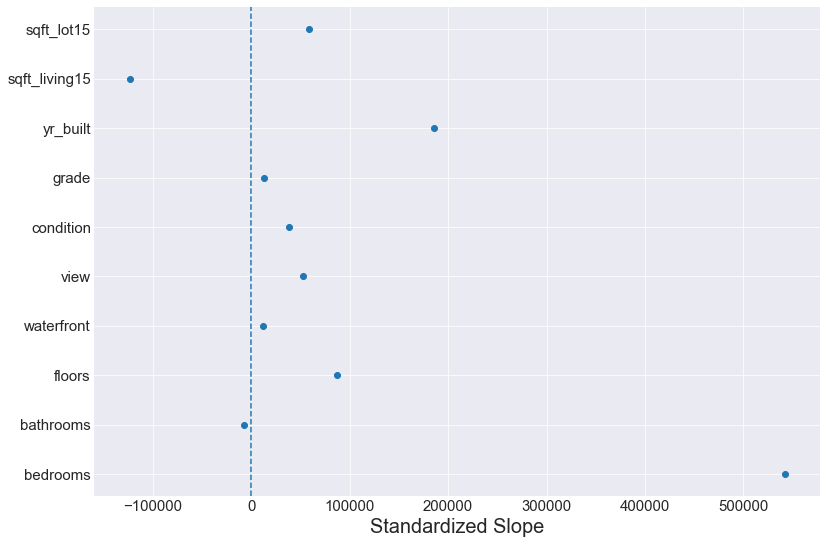

In [43]:
fig, ax = plt.subplots(figsize=(13,9))
plt.errorbar(xs, ys, xerr=x_err, fmt='o')
plt.axvline(x=0.0, linestyle='dashed')
ax.set_yticks(ys)
ax.set_yticklabels(labels)
ax.set_xlabel('Standardized Slope', fontsize=20)
plt.show()

The most important feature is the number of bedrooms, followed by yr_built and sqft_living. These features make sense as the larger a house is, generally the more expensive it it. Also, if a house was built more recently it will probably also be expensive.

We have exlcuded location (**lat**, **long** and **zipcode**) from our analysis to keep our models simple, but these would have undoubtedly been telling indicators of price if a clustering model had been implemented - houses are more expensive in good areas e.g. along the coast as we saw in our visualization.

We now know the most important and least important indicators of a houses price. Going forward, we can use this information to collect more data on house price using these features or variations of them to build an even more powerful model.


# Conclusions

We saw that the data has some multicolinearity issues, as well as some features being weakly correlated with each other. We managed to iterate through a model fitting process that identified the weakest features and we eliminated them at each stage, leaving us with a strong predictive model with $R^2 \approx 0.65$ and no colinearity issues. Model 3 uses 4 less features than model 1, yet achieves a similar degree of accuracy and has no colinearity issues.

### Model Recommendations

This really depends on what the end goal is / end user wants from the model.

If the goal is to find the most accurate model, then that is model 1 using all the features, as this has the lowest RSS and a high $R^2$ value.

However, if the goal is to best understand our features and have a robust model free of colinearity issues, then model 2 is the best choice, as this has equal predictive power as model 1 with similar $R^2$, but a slightly higher error RSS.